In [25]:
import uproot as up
import mplhep as hep
import numpy as np
import hist
from hist import Hist


import matplotlib.pyplot as plt

In [26]:
DataPtEta = up.open("/data/submit/mori25/dark_photons_ludo/DimuonTrees/tagnprobe/PassingProbeSoftId/Probe_pt_Probe_abs_eta/Data.root")
HallDataPtEta=DataPtEta['histograms']['all_nominal']
HpassDataPtEta=DataPtEta['histograms']['pass_nominal']
EffDataPtEta = up.open("/data/submit/mori25/dark_photons_ludo/DimuonTrees/tagnprobe/PassingProbeSoftId/Probe_pt_Probe_abs_eta/Data.root")["PassingProbeSoftId_Probe_abs_eta_Probe_pt_Nominal_Efficiency"]

MCPtEta = up.open("/data/submit/mori25/dark_photons_ludo/DimuonTrees/tagnprobe/PassingProbeSoftId/Probe_pt_Probe_abs_eta/MC.root")
HallMCPtEta=MCPtEta['histograms']['all_nominal']
HpassMCPtEta=MCPtEta['histograms']['pass_nominal']
EffMCPtEta = up.open("/data/submit/mori25/dark_photons_ludo/DimuonTrees/tagnprobe/PassingProbeSoftId/Probe_pt_Probe_abs_eta/MC.root")["PassingProbeSoftId_Probe_abs_eta_Probe_pt_Nominal_Efficiency"]


DataPtMm_dR = up.open("/data/submit/mori25/dark_photons_ludo/DimuonTrees/tagnprobe/PassingProbeSoftId/Probe_pt_Mm_dR/Data.root")
HallDataPtMm_dR=DataPtMm_dR['histograms']['all_nominal']
HpassDataPtMm_dR=DataPtMm_dR['histograms']['pass_nominal']
EffDataPtMm_dR = up.open("/data/submit/mori25/dark_photons_ludo/DimuonTrees/tagnprobe/PassingProbeSoftId/Probe_pt_Mm_dR/Data.root")["PassingProbeSoftId_Mm_dR_Probe_pt_Nominal_Efficiency"]


MCPtMm_dR = up.open("/data/submit/mori25/dark_photons_ludo/DimuonTrees/tagnprobe/PassingProbeSoftId/Probe_pt_Mm_dR/MC.root")
HallMCPtMm_dR=MCPtMm_dR['histograms']['all_nominal']
HpassMCPtMm_dR=MCPtMm_dR['histograms']['pass_nominal']
EffMCPtMm_dR = up.open("/data/submit/mori25/dark_photons_ludo/DimuonTrees/tagnprobe/PassingProbeSoftId/Probe_pt_Mm_dR/MC.root")["PassingProbeSoftId_Mm_dR_Probe_pt_Nominal_Efficiency"]


In [27]:
import matplotlib.ticker as ticker
class eff2d:
    def __init__(self,hallData, hpassData, hallMC, hpassMC,qY):
        self.hallData=hallData
        self.hpassData=hpassData
        self.hallMC=hallMC
        self.hpassMC=hpassMC
        self.qY=qY


    def plot_eff(self,dataOrMC):
        if dataOrMC=="data":
            eff, err, pt, eta = self.get_eff(self.hallData,self.hpassData,False)
        elif dataOrMC=="MC":
            eff, err, pt, eta = self.get_eff(self.hallMC,self.hpassMC,True)
        else:
            print("Choose data or MC")
        # N = hist.Hist("Efficiency").Double()
        # N.fill(eta,pt,eff)
        self.plot(eff,pt,eta,err=err,ylabel=self.qY)


    def get_SF(self,plot=True,errMethod="Gauss"):
        effData, errData, ptData, etaData = self.get_eff(self.hallData,self.hpassData,False)
        effMC, errMC, ptMC, etaMC = self.get_eff(self.hallMC,self.hpassMC,True)
        SF =  np.where(effMC==0,np.nan, effData/effMC)
        if errMethod == "Gauss": err = SF*np.sqrt((errData/effData)**2 + (errMC/effMC)**2)
        elif errMethod == "diff": err = np.abs(effMC-effData)
        else: err = 0*SF
        if plot: self.plot(SF,ptData,etaData,err=err,ylabel=self.qY)
        return SF,err,ptData,etaData

    def plot_frequency(self,file,vars):
        with up.open(file) as f:
            var1=f['tree'][vars[0]]
            var2=f['tree'][vars[1]]
            eff, err, pt, qY = self.get_eff(self.hallData,self.hpassData,True) #isMC is irrelevant here: only need the kinematic bins from get_eff
            H = (
                Hist.new.Variable(pt, name="pt")
                .Variable(qY, name="qY")
                .Double()
            )
            H.fill(var1,var2)
            self.plot(*H.to_numpy(),err=None,int_w=True,ylabel=vars[1])

    def integrate_sf(self,errMethod="Gauss",require_probe=True, extend_dR=None, overflow_sf=0,overflow_sf_err=0):
        DY = "/data/submit/mori25/dark_photons_ludo/DimuonTrees/MC_lmDY/DP/TP_samples_DP.root"
        with up.open(DY) as f:
            var1=f['tree']["Probe_pt"].array(library='np')
            var2=f['tree'][self.qY].array(library='np')
            probe=f['tree']["PassingProbeSoftId"].array(library='np')==1
            SF, err, pt, var = self.get_SF(plot=False,errMethod=errMethod)
            if extend_dR is not None:
                var = np.append(var,np.array([extend_dR]))
                SF = np.hstack((SF,np.array([np.array([overflow_sf]) for i in range(len(pt)-1)])))
                err = np.hstack((err,np.array([np.array([overflow_sf_err]) for i in range(len(pt)-1)])))
                
            H = (
                Hist.new.Variable(pt, name="pt")
                .Variable(var, name=self.qY)
                .Double()
            )
            if require_probe: H.fill(var1[probe],var2[probe])
            else: H.fill(var1,var2)

            I = np.sum(H.values()*np.where(np.isnan(SF),overflow_sf,SF))/np.sum(H.values())
            Ierr = np.sum(H.values()*np.where(np.isnan(err), overflow_sf_err, err))/np.sum(H.values())
            return I,Ierr
        
    @staticmethod
    def get_eff(Hall,Hpass,isMC):
        hall,pt,qY = Hall.to_numpy()
        hpass,pt,qY = Hpass.to_numpy()
        eff = np.where(hall==0,np.nan, hpass/hall)
        if (isMC):  err =np.where(hall==0,np.nan, np.sqrt(eff*(1-eff)/hall))
        else :
            err = eff*np.sqrt((Hpass.errors()/hpass)**2 + (Hall.errors()/hall)**2 + (1-eff)/hall/eff); #sum in quadrature of fit and normal binomial (relative errors)
        return eff, err, pt, qY
    
    @staticmethod
    def plot(w,x,y,ylabel=None,err=None,int_w=False):
        hep.style.use("CMS")
        fig, ax = plt.subplots(figsize=(12,10))
        hep.cms.label("Preliminary",data=True,lumi=62.4,com=13.6)
        mesh = ax.pcolormesh(x, y, w.T, cmap="coolwarm")#autumn
        #add to each bin the value with the error
       
        for i in range(len(x)-1):
            for j in range(len(y)-1):
                if not np.isnan(w[i,j]):
                    if int_w : ax.text(1.1*x[i],(y[j]+y[j+1])/2,f"{int(w[i,j])}" + (f" $\pm$ {int(err[i,j])}" if err is not None else ""),fontsize=12,color="black",ha="center",va="center",weight='bold')
                    else : ax.text(1.1*x[i],(y[j]+y[j+1])/2,f"{w[i,j]:.3f}" + (f"\n $\pm$ {err[i,j]:.3f}" if err is not None else ""),fontsize=12,color="black",ha="center",va="center",weight='bold')
        ax.set_xlabel("$p_T$")

        s=""
        if ylabel=="Probe_abs_eta":s= "$|\eta|$"
        elif ylabel=="Mm_dR":s= "$\Delta R$"

        ax.set_ylabel(s)
        ax.set_xscale("log")
        # ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:0.0f}'.format(x)))
        # ax.set_xticks([4, 10, 20])
        # ax.get_xaxis().set_major_formatt
        plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
        plt.gca().xaxis.set_minor_formatter(ticker.ScalarFormatter())
        # ax.ticklabel_format(style='plain')
        fig.colorbar(mesh)
        ax.legend()
        plt.show()  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.9911940385624443 +/- 0.008592094004940178
0.9911940385624443 +/- 0.006205925883379709


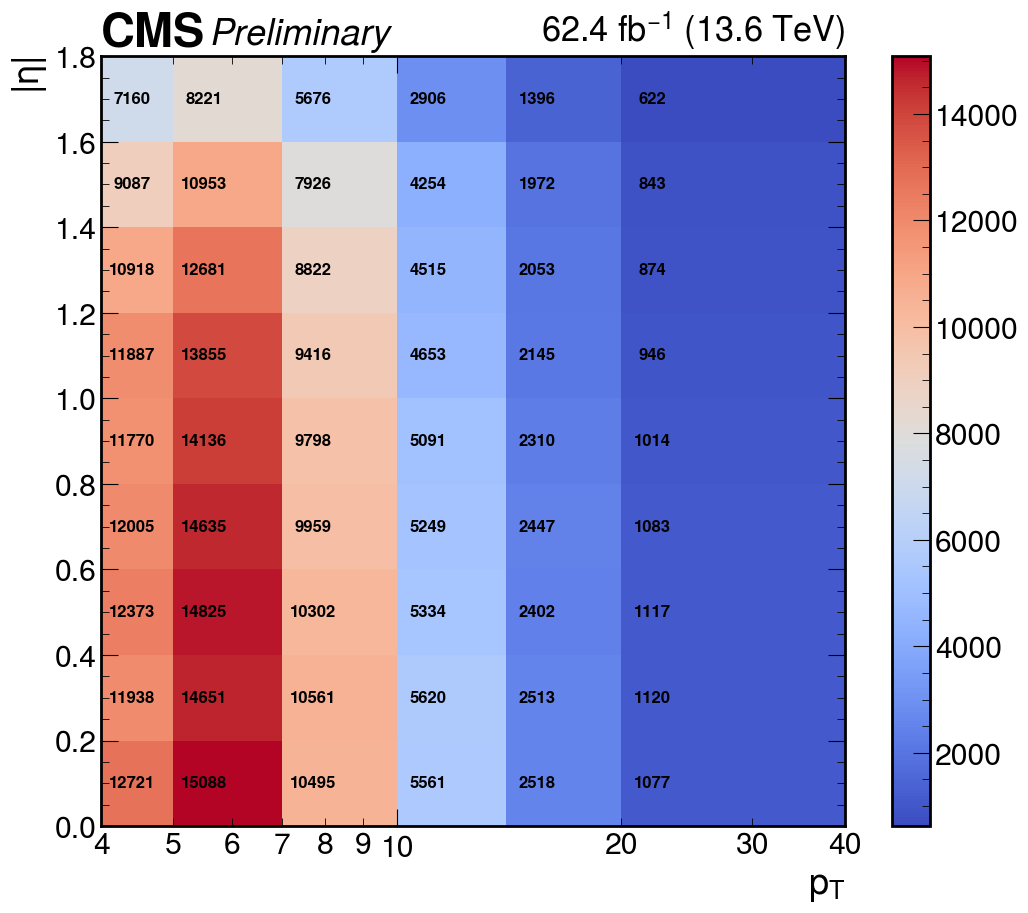

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


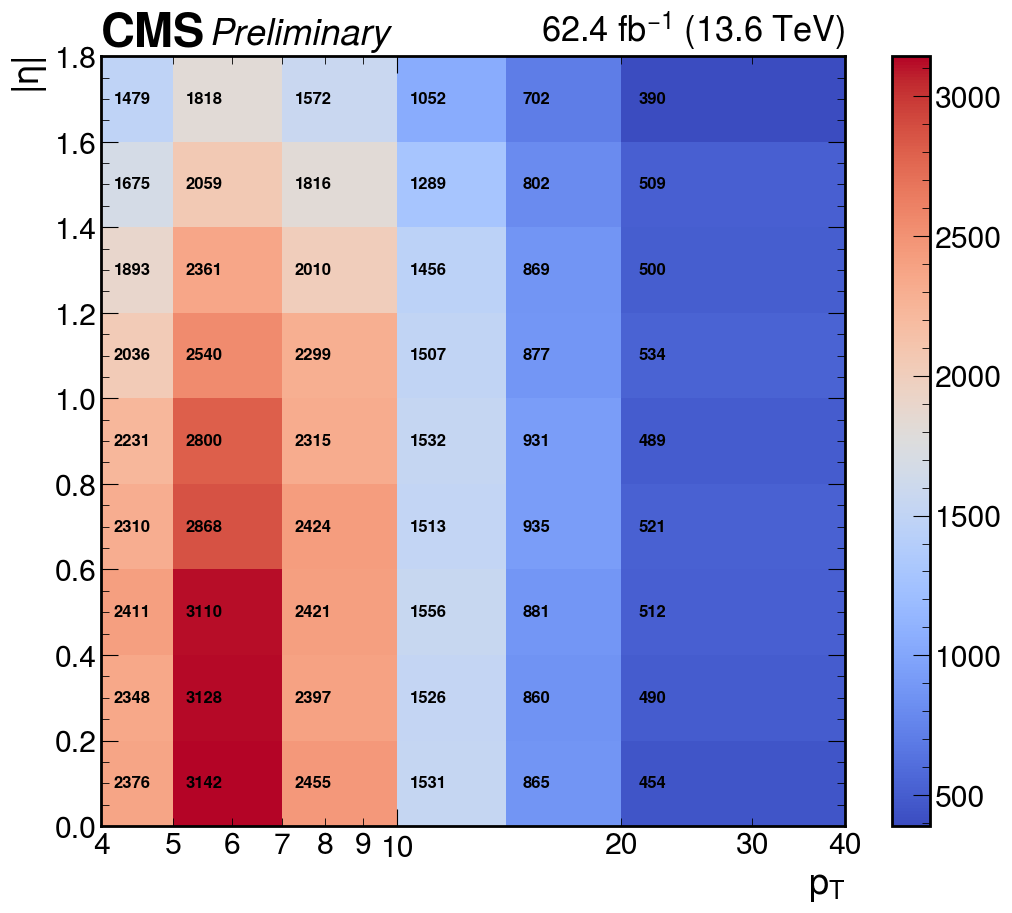

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


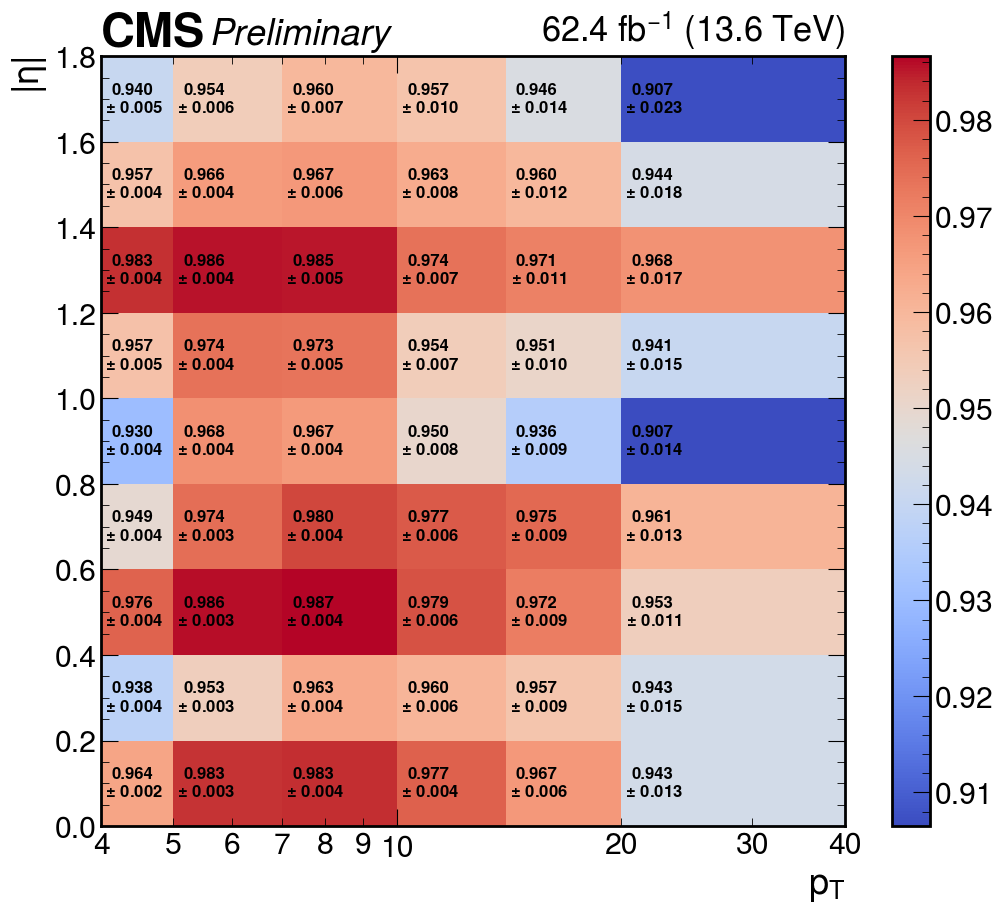

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


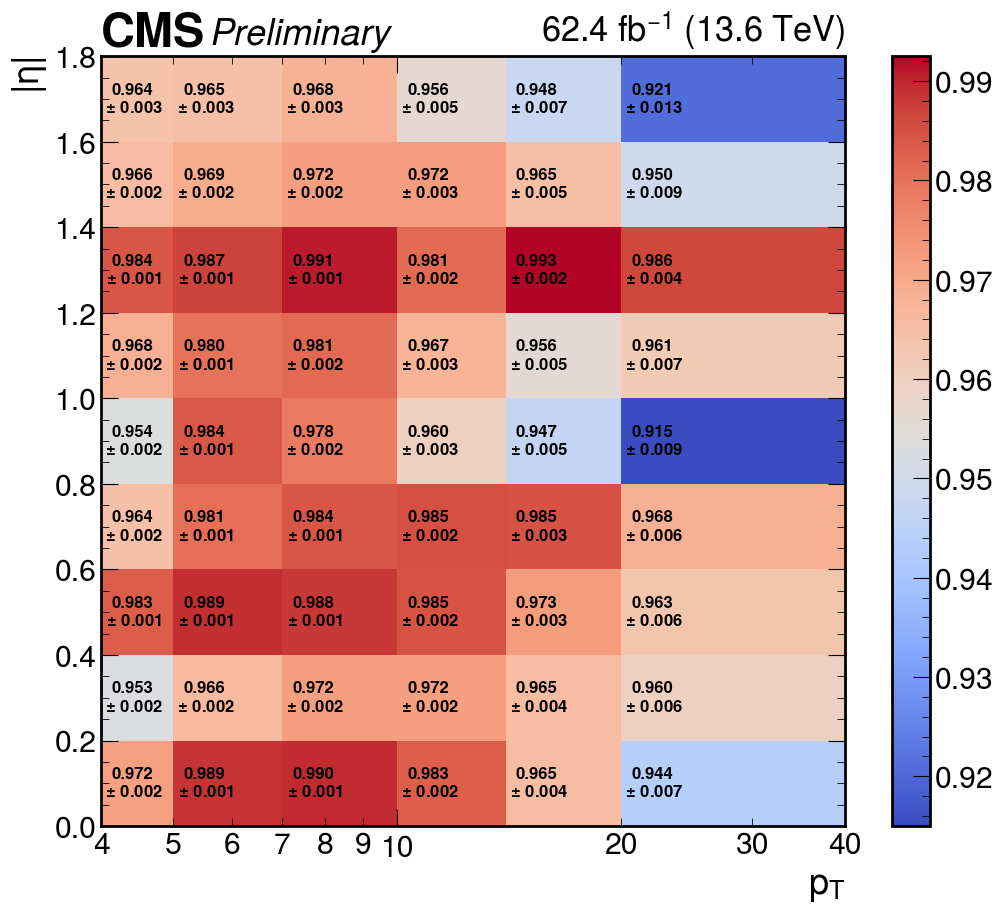

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


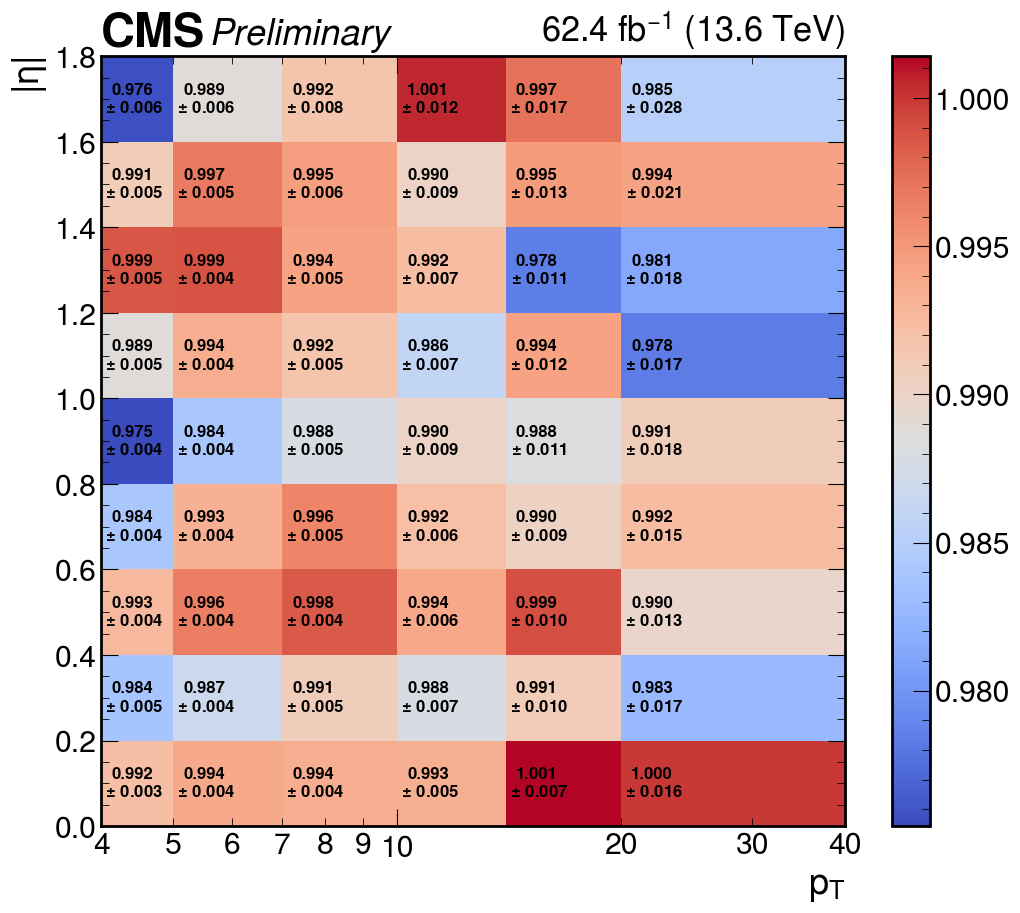

In [28]:
I,Ierr = eff2d(HallDataPtEta,HpassDataPtEta,HallMCPtEta,HpassMCPtEta,"Probe_abs_eta").integrate_sf(errMethod="diff")
print(I,"+/-",Ierr)

I,Ierr = eff2d(HallDataPtEta,HpassDataPtEta,HallMCPtEta,HpassMCPtEta,"Probe_abs_eta").integrate_sf(errMethod="Gauss")
print(I,"+/-",Ierr)

eff2d(HallDataPtEta,HpassDataPtEta,HallMCPtEta,HpassMCPtEta,"Probe_abs_eta").plot_frequency("/data/submit/mori25/dark_photons_ludo/DimuonTrees/MC_InclusiveMinBias/Jpsi/TP_samples_Jpsi.root",["Probe_pt","Probe_abs_eta"])
eff2d(HallDataPtEta,HpassDataPtEta,HallMCPtEta,HpassMCPtEta,"Probe_abs_eta").plot_frequency("/data/submit/mori25/dark_photons_ludo/DimuonTrees/MC_lmDY/DP/TP_samples_DP.root",["Probe_pt","Probe_abs_eta"])
eff2d(HallDataPtEta,HpassDataPtEta,HallMCPtEta,HpassMCPtEta,"Probe_abs_eta").plot_eff("data")
eff2d(HallDataPtEta,HpassDataPtEta,HallMCPtEta,HpassMCPtEta,"Probe_abs_eta").plot_eff("MC")
_ = eff2d(HallDataPtEta,HpassDataPtEta,HallMCPtEta,HpassMCPtEta,"Probe_abs_eta").get_SF()

/tmp/ipykernel_1373771/2749672098.py:74: RuntimeWarning: invalid value encountered in divide
  eff = np.where(hall==0,np.nan, hpass/hall)


0.9117014442792295 $\pm$ 0.009395595313968573
0.9915191928086318 +/- 0.017554748150939076
1.0008840419965668 +/- 0.017554748150939076
0.9821543436206965 +/- 0.017554748150939076
Delta up - down:  0.01872969837587024
Total rel unc :  0.025889994300575047
Total abs unc :  0.02567042625072625
0.9117014442792295 +/- 0.008010459120583764


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


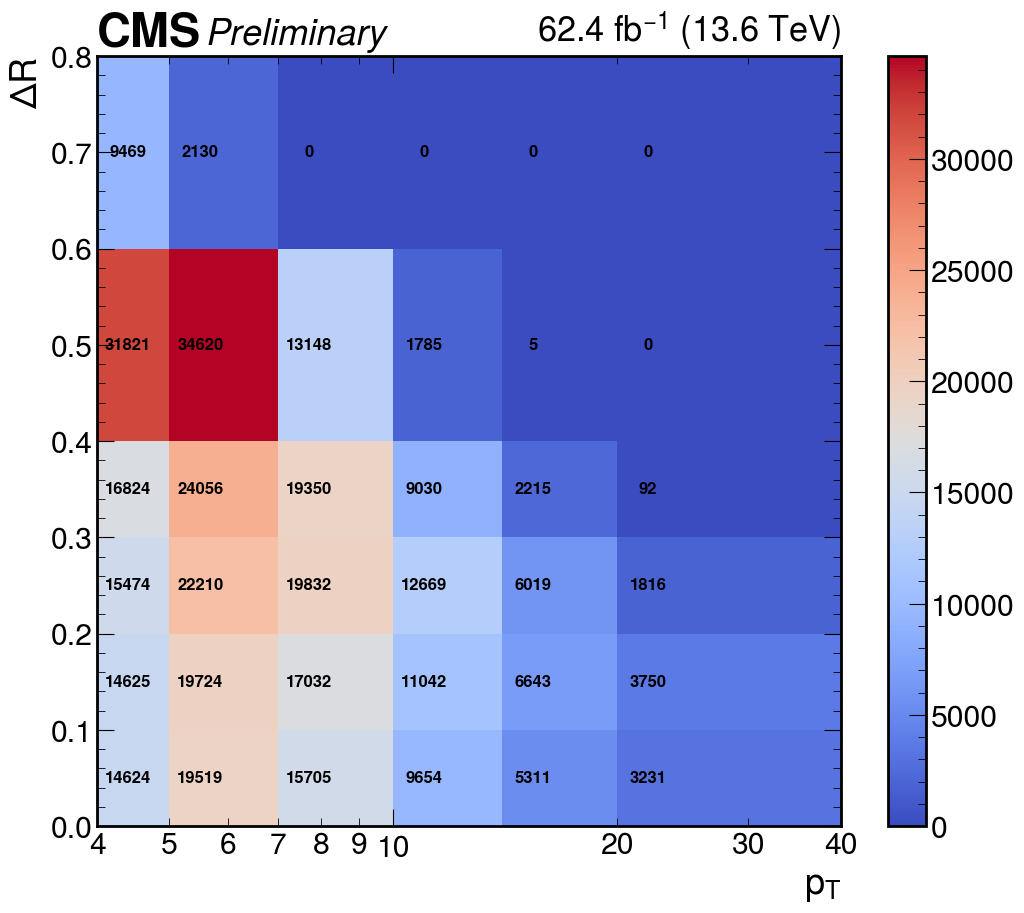

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


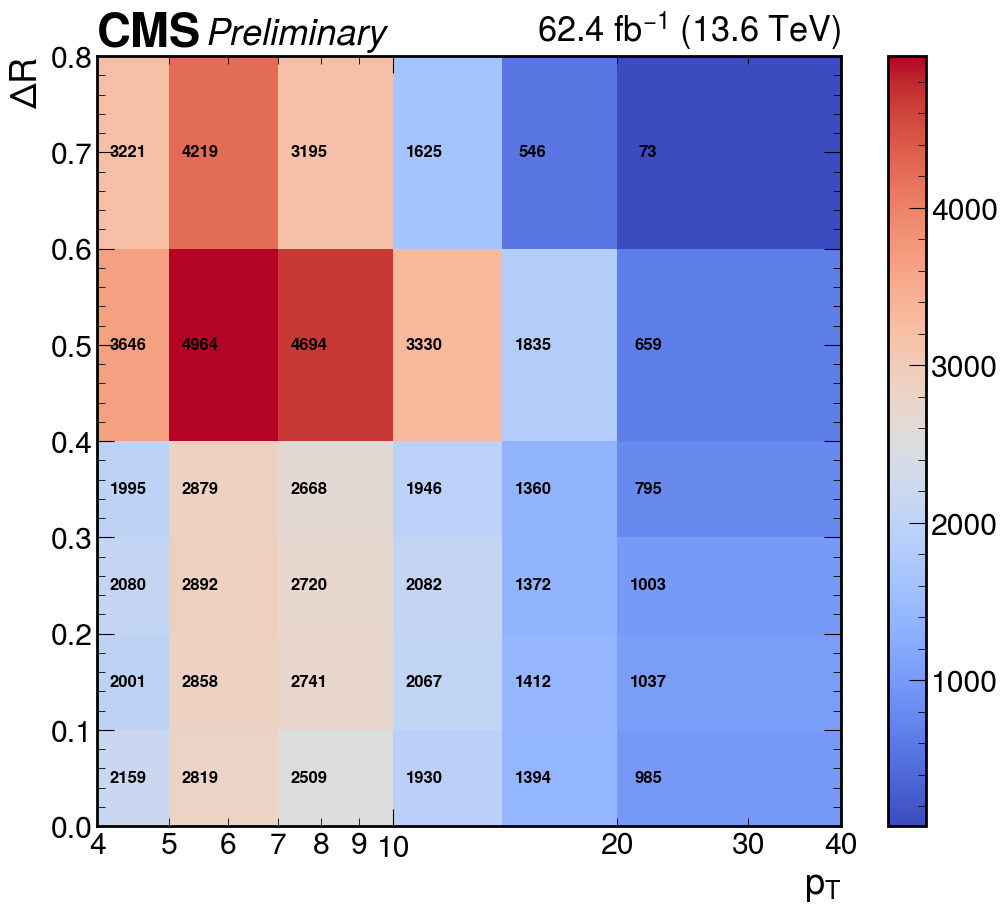

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


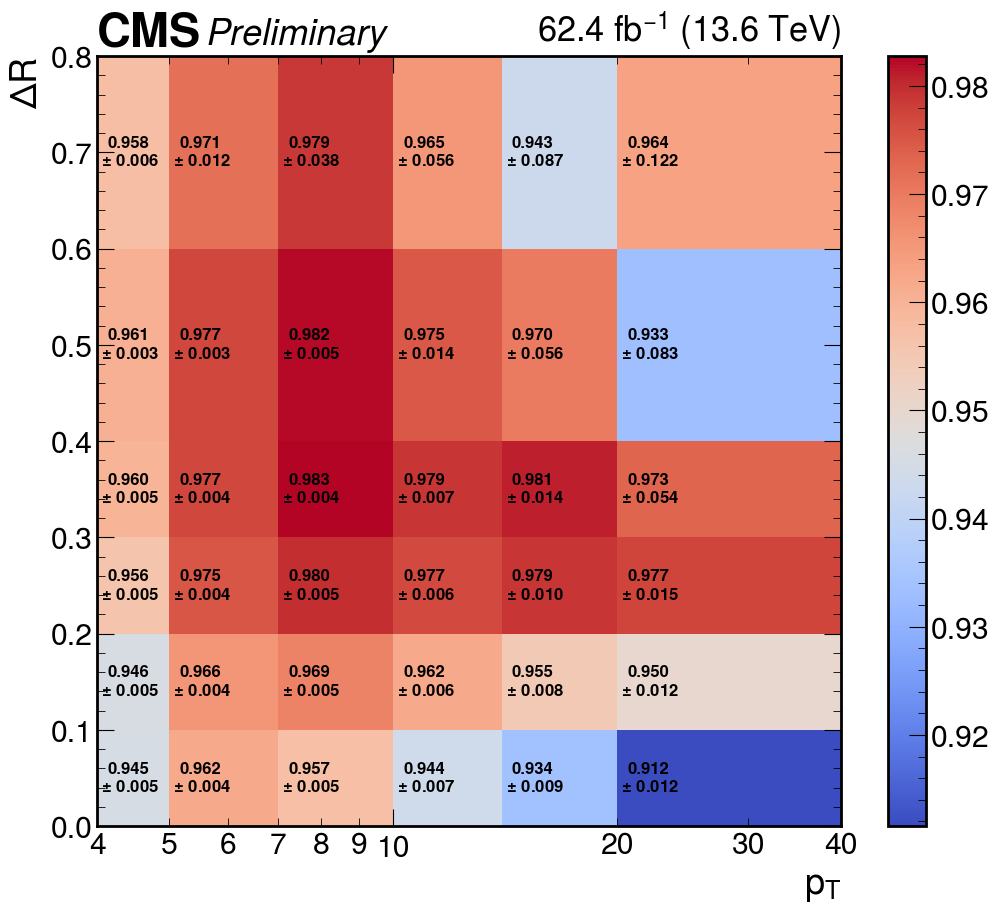

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


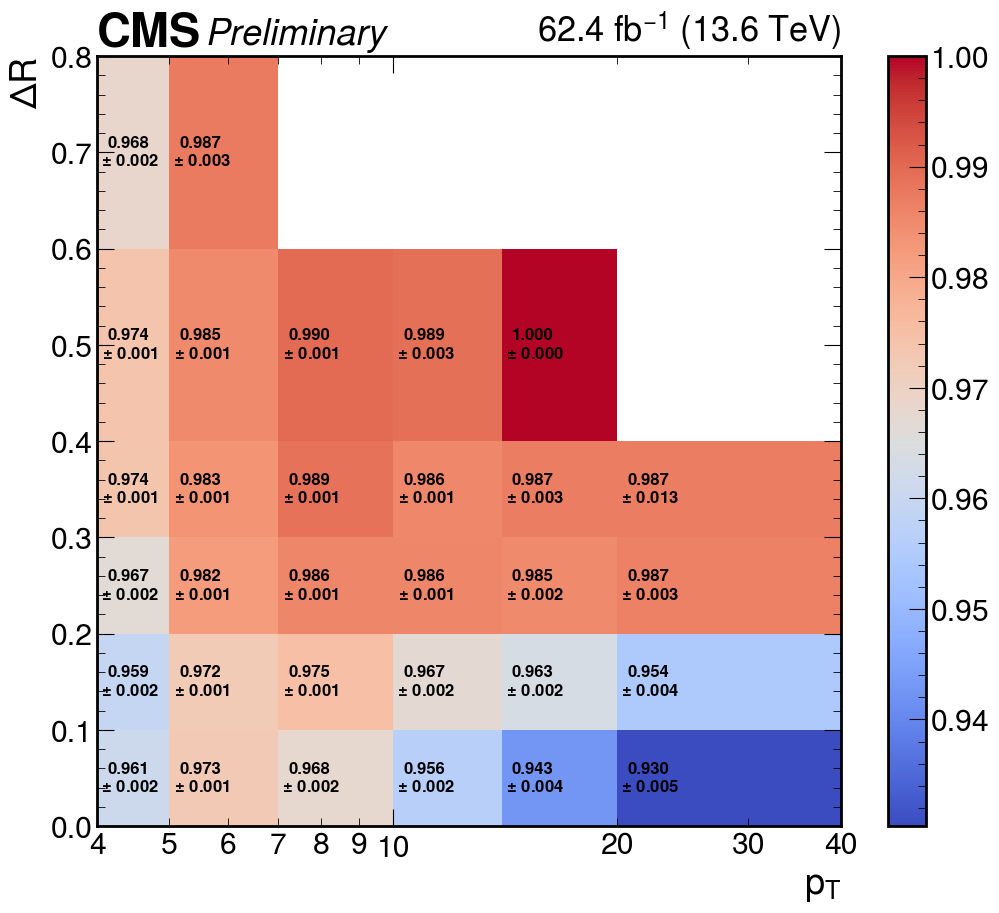

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


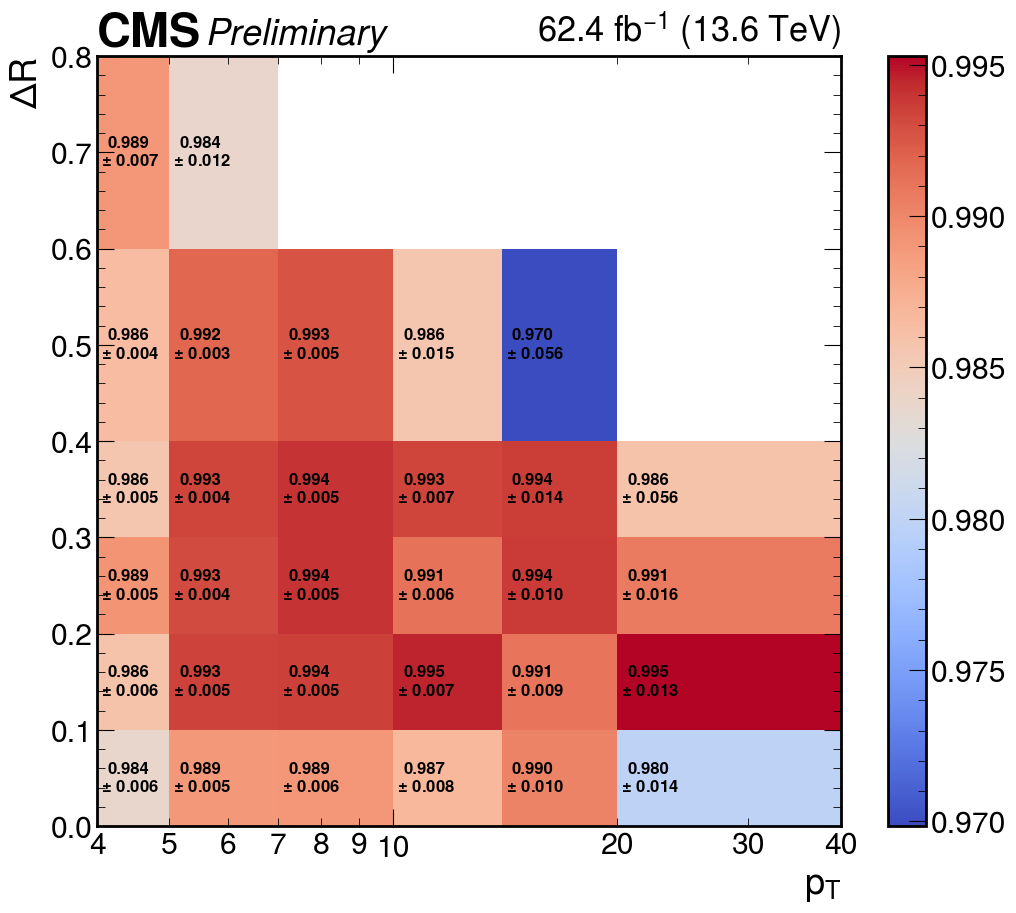

In [29]:
I,Ierr = eff2d(HallDataPtMm_dR,HpassDataPtMm_dR,HallMCPtMm_dR,HpassMCPtMm_dR,"Mm_dR").integrate_sf(errMethod="diff")
print(I,"$\pm$",Ierr)

I,Ierr = eff2d(HallDataPtMm_dR,HpassDataPtMm_dR,HallMCPtMm_dR,HpassMCPtMm_dR,"Mm_dR").integrate_sf(errMethod="Gauss",require_probe=True, extend_dR=1.5,overflow_sf=1,overflow_sf_err=0.056)
print(I,"+/-",Ierr)

Iup,Ierr = eff2d(HallDataPtMm_dR,HpassDataPtMm_dR,HallMCPtMm_dR,HpassMCPtMm_dR,"Mm_dR").integrate_sf(errMethod="Gauss",require_probe=True, extend_dR=1.5,overflow_sf=1.05,overflow_sf_err=0.056)
print(Iup,"+/-",Ierr)

Idown,Ierr = eff2d(HallDataPtMm_dR,HpassDataPtMm_dR,HallMCPtMm_dR,HpassMCPtMm_dR,"Mm_dR").integrate_sf(errMethod="Gauss",require_probe=True, extend_dR=1.5,overflow_sf=0.95,overflow_sf_err=0.056)
print(Idown,"+/-",Ierr)

print("Delta up - down: ", Iup-Idown)
print("Total rel unc : ", np.sqrt((Ierr/I)**2 + ((Iup-Idown)/I)**2))
print("Total abs unc : ", np.sqrt((Ierr/I)**2 + ((Iup-Idown)/I)**2)*I)

I,Ierr = eff2d(HallDataPtMm_dR,HpassDataPtMm_dR,HallMCPtMm_dR,HpassMCPtMm_dR,"Mm_dR").integrate_sf(errMethod="Gauss",require_probe=True, extend_dR=None)
print(I,"+/-",Ierr)


eff2d(HallDataPtMm_dR,HpassDataPtMm_dR,HallMCPtMm_dR,HpassMCPtMm_dR,"Mm_dR").plot_frequency("/data/submit/mori25/dark_photons_ludo/DimuonTrees/MC_InclusiveMinBias/Jpsi/TP_samples_Jpsi.root",["Probe_pt","Mm_dR"])
eff2d(HallDataPtMm_dR,HpassDataPtMm_dR,HallMCPtMm_dR,HpassMCPtMm_dR,"Mm_dR").plot_frequency("/data/submit/mori25/dark_photons_ludo/DimuonTrees/MC_lmDY/DP/TP_samples_DP.root",["Probe_pt","Mm_dR"])
eff2d(HallDataPtMm_dR,HpassDataPtMm_dR,HallMCPtMm_dR,HpassMCPtMm_dR,"Mm_dR").plot_eff("data")
eff2d(HallDataPtMm_dR,HpassDataPtMm_dR,HallMCPtMm_dR,HpassMCPtMm_dR,"Mm_dR").plot_eff("MC")
_= sf = eff2d(HallDataPtMm_dR,HpassDataPtMm_dR,HallMCPtMm_dR,HpassMCPtMm_dR,"Mm_dR").get_SF()